<font color="#006400"><h1>Mental Disorder Diagnostic Support Project</h1></font>
This project aims to fine-tune Bio_ClinicalBERT for mental disorder diagnostic support, specifically for mental health clinicians.

The goal is to build a model that:
- Provides **mental disorder** predictions
- Provides **explainable** predictions
- Collects **feedback** for continuous improvement    

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import os
import random
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer
import logging
import warnings

import seaborn as sns
import pandas as pd
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from transformers import AutoModelForSequenceClassification, AutoTokenizer
from peft import LoraConfig, get_peft_model, TaskType, PeftModel

from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.cuda.amp import autocast, GradScaler
from torch.nn.utils import clip_grad_norm_
from transformers import AutoConfig
import json

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

from nltk.corpus import stopwords
from nltk import ngrams
try:
    stop_words = set(stopwords.words("english"))
except LookupError:
    import nltk
    nltk.download('stopwords')
    stop_words = set(stopwords.words("english"))

# Suppress warnings and logging messages
warnings.filterwarnings('ignore')
logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)

<font color="#006400"><h1>Part I - Initial EDA Data Preprocessing</h1></font>

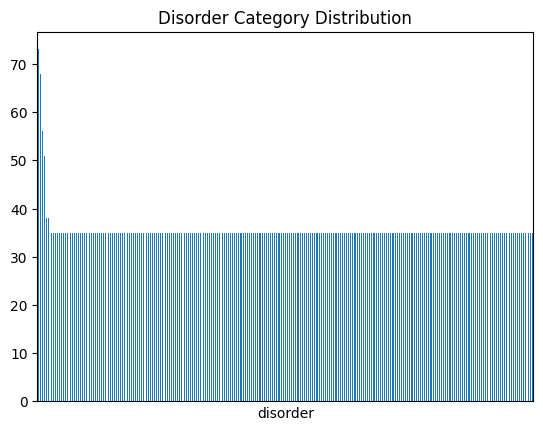

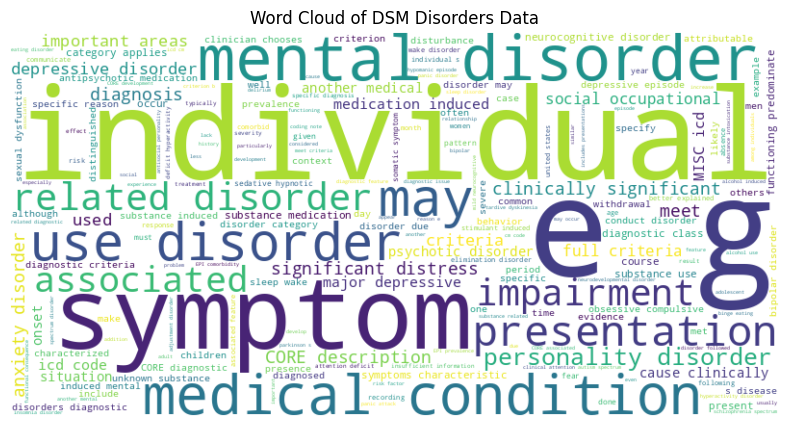

In [2]:
# data loading and plotting
df = pd.read_csv('clean_dsm_resampled.csv')

df["disorder"].value_counts().plot(kind="bar", title="Disorder Category Distribution")
plt.xticks([])
plt.show()

all_text = " ".join(
    str(content)
    for column in ['text']
    for content in df[column].dropna()
)

word_freq = Counter(all_text.split())

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of DSM Disorders Data")
plt.show()


In [3]:
# Preprocessing, splitting, tokenizing

# 'disorder' column is of categorical type
df['disorder'] = df['disorder'].astype('category')

# train_test_split
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df["disorder"])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df["disorder"])

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

# Encode the disorder column into numerical labels
label_encoder = LabelEncoder()
train_df["disorder_label"] = label_encoder.fit_transform(train_df["disorder"])
val_df["disorder_label"] = label_encoder.transform(val_df["disorder"])
test_df["disorder_label"] = label_encoder.transform(test_df["disorder"])

# Save the label mappings for later use
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mappings:", label_mapping)

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

# Utility: Split text into chunks
def split_text_into_chunks(text, max_length, tokenizer, overlap=50):
    tokens = tokenizer.tokenize(text)

    # Check if the text is shorter than the max_length
    if len(tokens) <= max_length:
        # If so, return the original text as a single chunk
        return [text]

    # Otherwise, proceed with the original chunking logic
    num_chunks = (len(tokens) - max_length) // (max_length - overlap) + 1
    chunks = []
    for i in range(num_chunks):
        start = i * (max_length - overlap)
        end = start + max_length
        chunk = tokens[start:end]
        chunk_text = tokenizer.convert_tokens_to_string(chunk)
        chunks.append(chunk_text)
    return chunks

class ClinicalDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=512, overlap=50):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.overlap = overlap

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        disorder_label = row["disorder_label"]
        text_chunks = split_text_into_chunks(row["text"], self.max_length, self.tokenizer, self.overlap)

        if not text_chunks:
            return {
                "input_ids": torch.tensor([tokenizer.pad_token_id] * self.max_length, dtype=torch.long).unsqueeze(0),
                "attention_mask": torch.zeros(1, self.max_length, dtype=torch.long),
                "labels": torch.tensor(disorder_label, dtype=torch.long)
            }

        tokenized_chunks = [
            self.tokenizer(
                chunk,
                max_length=self.max_length,
                truncation=True,
                padding="max_length",
                return_tensors="pt"
            )
            for chunk in text_chunks
        ]
        return [{
            "input_ids": chunk["input_ids"],
            "attention_mask": chunk["attention_mask"],
            "labels": torch.tensor(disorder_label, dtype=torch.long)
        } for chunk in tokenized_chunks]

def collate_fn(batch):
    if isinstance(batch[0], list):
        batch = [item for sublist in batch for item in sublist]
    else:
        batch = [batch]

    max_len = max(item["input_ids"].shape[1] for item in batch)

    input_ids = []
    attention_mask = []
    labels = []

    for item in batch:
        if item["input_ids"].shape[1] < max_len:
            padding_size = max_len - item["input_ids"].shape[1]
            padding_tensor = torch.tensor([tokenizer.pad_token_id] * padding_size,
                                          dtype=item["input_ids"].dtype,
                                          device=item["input_ids"].device)
            padded_input_ids = torch.cat([item["input_ids"][0], padding_tensor])
            input_ids.append(padded_input_ids)
            padding_tensor_attn = torch.tensor([0] * padding_size,
                                              dtype=item["attention_mask"].dtype,
                                              device=item["attention_mask"].device)
            padded_attention_mask = torch.cat([item["attention_mask"][0], padding_tensor_attn])
            attention_mask.append(padded_attention_mask)
        else:
            input_ids.append(item["input_ids"][0])
            attention_mask.append(item["attention_mask"][0])

        labels.append(item["labels"])

    input_ids = torch.stack(input_ids)
    attention_mask = torch.stack(attention_mask)
    labels = torch.stack(labels)

    return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}

# Define separate datasets for each split
train_dataset = ClinicalDataset(train_df, tokenizer, max_length=512)
val_dataset = ClinicalDataset(val_df, tokenizer, max_length=512)
test_dataset = ClinicalDataset(test_df, tokenizer, max_length=512)

# for pre-tuning model evaluation
sample_size = 50
sample_indices = random.sample(range(len(train_dataset)), sample_size)
subset_dataset = Subset(train_dataset, sample_indices)



# Define DataLoaders for each split
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)
subset_loader = DataLoader(subset_dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=False) # DataLoader for the subset

# Print DataLoader sizes
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")
print(f"Subset batches: {len(subset_loader)}")


Training set size: 5837
Validation set size: 1251
Test set size: 1251
Label Mappings: {'acute stress disorder': 0, 'additional codes': 1, 'additional conditions or problems that may be a focus of clinical attention': 2, 'adjustment disorders': 3, 'agoraphobia': 4, 'alcohol intoxication ': 5, 'alcohol use disorder': 6, 'alcohol withdrawal': 7, 'alcohol-induced mental disorders': 8, 'anorexia nervosa': 9, 'antidepressant discontinuation syndrome': 10, 'antisocial personality disorder': 11, 'anxiety disorder due to another medical condition': 12, 'attention-deficit/hyperactivity disorder (adhd)': 13, 'autism spectrum disorder': 14, 'avoidant personality disorder': 15, 'avoidant/restrictive food intake disorder': 16, 'binge-eating disorder': 17, 'bipolar and related disorder due to another medical condition': 18, 'bipolar i disorder': 19, 'bipolar ii disorder': 20, 'body dysmorphic disorder': 21, 'borderline personality disorder': 22, 'breathing-related sleep disorders': 23, 'brief psychot

<font color="#006400"><h1>Part II - Model Inisilization and Pre-tuning Evaluation</h1></font>

In [4]:
# Initializing base moel
num_labels = len(label_mapping)

# Initialize the model
model = AutoModelForSequenceClassification.from_pretrained(
    "emilyalsentzer/Bio_ClinicalBERT",
    num_labels=num_labels
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f"Model initialized with {num_labels} labels and moved to {device}")

Model initialized with 235 labels and moved to cuda


In [5]:
# defining an evaluation function
def evaluate_model(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    all_predictions = []
    all_labels = []
    total_loss = 0  # Initialize total loss

    with torch.no_grad():  # Disable gradient calculation
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            # Get the attention mask from the batch (it's already a tensor)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)  # Move labels to device

            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)  # Calculate loss using criterion
            total_loss += loss.item()  # Accumulate loss

            _, predictions = torch.max(outputs.logits, dim=1)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(data_loader)  # Calculate average loss
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    metrics = {
        'avg_loss': avg_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

    return metrics

In [6]:
# Base model pre-tuning performance metrics
criterion = nn.CrossEntropyLoss()

print("Starting pre-fine-tuning evaluation...\n")
metrics = evaluate_model(model, subset_loader)  # Store the returned dictionary
print('Pre-tuning Model Evaluation Results:')
print(f'AvgLoss: {metrics["avg_loss"] * 100:.2f}%')
print(f'Accuracy: {metrics["accuracy"] * 100:.2f}%')
print(f'Precision: {metrics["precision"] * 100:.2f}%')
print(f'Recall: {metrics["recall"] * 100:.2f}%')
print(f'F1: {metrics["f1"] * 100:.2f}%')

Starting pre-fine-tuning evaluation...

Pre-tuning Model Evaluation Results:
AvgLoss: 562.02%
Accuracy: 0.00%
Precision: 0.00%
Recall: 0.00%
F1: 0.00%


<font color="#006400"><h1>Part III - Fine-Tune Model With PEFT Config</h1></font>

In [7]:
# LoRA configuration on model
model_name = "emilyalsentzer/Bio_ClinicalBERT"
tokenizer = AutoTokenizer.from_pretrained(model_name)

num_labels = len(label_mapping)

base_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    attn_implementation="eager"
)

# Define LoRA configuration
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    r=8,
    lora_alpha=8,
    lora_dropout=0.3
)

model = get_peft_model(base_model, lora_config).to(device)
model.print_trainable_parameters()

trainable params: 475,627 || all params: 108,966,614 || trainable%: 0.4365


Starting training...

Epoch 1
Loss: 4.5529  Accuracy: 5.64%  Precision: 3.51%  Recall: 5.64%  F1: 3.14%
F1 improvement: 3.14% ..saving model...

Epoch 2
Loss: 2.1301  Accuracy: 49.10%  Precision: 51.78%  Recall: 49.10%  F1: 44.35%
F1 improvement: 41.21% ..saving model...

Epoch 3
Loss: 1.1253  Accuracy: 71.34%  Precision: 75.68%  Recall: 71.34%  F1: 69.80%
F1 improvement: 25.45% ..saving model...

Epoch 4
Loss: 0.6723  Accuracy: 85.51%  Precision: 88.58%  Recall: 85.51%  F1: 84.87%
F1 improvement: 15.08% ..saving model...

Epoch 5
Loss: 0.4998  Accuracy: 88.02%  Precision: 89.71%  Recall: 88.02%  F1: 87.35%
F1 improvement: 2.48% ..saving model...

Epoch 6
Loss: 0.3895  Accuracy: 91.70%  Precision: 93.76%  Recall: 91.70%  F1: 91.35%
F1 improvement: 4.00% ..saving model...

Epoch 7
Loss: 0.3161  Accuracy: 93.89%  Precision: 95.00%  Recall: 93.89%  F1: 93.80%
F1 improvement: 2.45% ..saving model...

Epoch 8
Loss: 0.3618  Accuracy: 93.58%  Precision: 94.85%  Recall: 93.58%  F1: 93.44%
No F

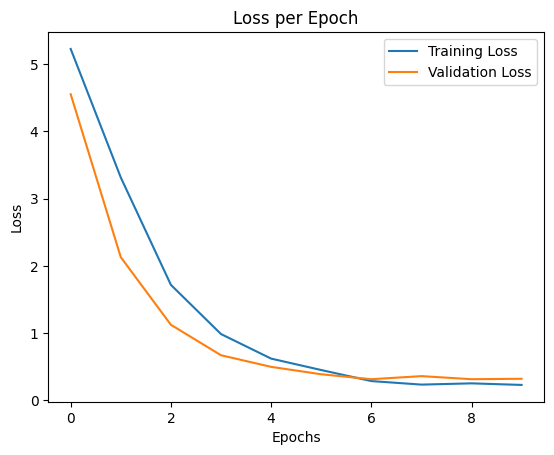

In [8]:
# Fine-tuning the model
save_directory = './psyai'
os.makedirs(save_directory, exist_ok=True)

criterion = nn.CrossEntropyLoss()

optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)

total_steps = len(train_loader) * 10
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)

scaler = GradScaler()

train_loss_values = []
val_loss_values = []

epochs = 10
patience = 3
no_improvement = 0
best_f1 = 0

print("Starting training...")

# Training loop
for epoch in range(epochs):
    if no_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}.")
        break

    total_train_loss = 0
    model.train()

    # Training phase
    for step, batch in enumerate(train_loader):
        input_ids = batch["input_ids"].to(device)
        attention_masks = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()

        with autocast():
            outputs = model(input_ids, attention_mask=attention_masks)
            loss = criterion(outputs.logits, labels)

        total_train_loss += loss.item()

        # Backpropagation
        scaler.scale(loss).backward()
        clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

    # Compute average training loss
    avg_train_loss = total_train_loss / len(train_loader)
    train_loss_values.append(avg_train_loss)

    # Validation phase
    metrics = evaluate_model(model, val_loader)
    avg_loss = metrics["avg_loss"]
    f1 = metrics["f1"]
    precision = metrics["precision"]
    recall = metrics["recall"]
    accuracy = metrics["accuracy"]

    # Store validation loss
    val_loss_values.append(metrics["avg_loss"])

    # Adjust learning rate based on validation loss
    scheduler.step(metrics["avg_loss"])

    print(f'\nEpoch {epoch + 1}')
    print(f'Loss: {avg_loss:.4f}  Accuracy: {accuracy * 100:.2f}%  Precision: {precision * 100:.2f}%  Recall: {recall * 100:.2f}%  F1: {f1 * 100:.2f}%')

    # Check for improvement
    if f1 > best_f1:
        improvement = f1 - best_f1
        print(f"F1 improvement: {improvement * 100:.2f}% ..saving model...")
        best_f1 = f1
        no_improvement = 0  # Reset the no improvement counter

        # Save the LoRA adapter configuration and weights
        adapter_save_path = os.path.join(save_directory, 'adapter')
        model.save_pretrained(adapter_save_path)

        # Save tokenizer and other model-related files
        tokenizer.save_pretrained(save_directory)
        config = AutoConfig.from_pretrained(model_name)
        config.save_pretrained(save_directory)

        # Save label mapping
        with open(os.path.join(save_directory, 'label_mapping.json'), 'w') as f:
            # Convert NumPy int64 values to Python int
            converted_label_mapping = {k: int(v) for k, v in label_mapping.items()}
            json.dump(converted_label_mapping, f)

        # Save training metadata
        training_metadata = {
            "learning_rate": optimizer.param_groups[0]['lr'],
            "epochs": epochs,
            "batch_size": train_loader.batch_size,
            "total_steps": total_steps,
            "best_f1": best_f1,
            "gradient_clipping": 1.0,
            "weight_decay": optimizer.param_groups[0].get('weight_decay', 0),
            "scheduler": str(scheduler.__class__.__name__)
        }
        with open(os.path.join(save_directory, 'training_metadata.json'), 'w') as f:
            json.dump(training_metadata, f)

        # Save best evaluation metrics
        best_metrics = {
            "f1_score": best_f1,
            "precision": precision,
            "recall": recall,
            "accuracy": accuracy
        }
        with open(os.path.join(save_directory, 'evaluation_metrics.json'), 'w') as f:
            json.dump(best_metrics, f)

    else:
        no_improvement += 1
        print(f"No F1 improvement at epoch {epoch+1}. Early stopping counter: {no_improvement}/{patience}")

print("Training completed. Best model saved.\n")

# Plot training and validation loss
plt.plot(train_loss_values, label="Training Loss")
plt.plot(val_loss_values, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()
plt.show()

<font color="#006400"><h1>Part IV - Fine-Tuned Model Evaluation</h1></font>

In [9]:
# Evaluate model on unseen data test
save_directory = './psyai'

print("Loading the LoRA adapter...")
model = PeftModel.from_pretrained(base_model, os.path.join(save_directory, 'adapter')).to(device)

print("Starting PsyAI evaluation...\n")
metrics = evaluate_model(model, test_loader)
avg_loss = metrics["avg_loss"]
f1 = metrics["f1"]
precision = metrics["precision"]
recall = metrics["recall"]
accuracy = metrics["accuracy"]

print(f'Loss: {avg_loss:.4f}  Accuracy: {accuracy * 100:.2f}%  Precision: {precision * 100:.2f}%  Recall: {recall * 100:.2f}%  F1: {f1 * 100:.2f}%')


Loading the LoRA adapter...
Starting PsyAI evaluation...

Loss: 0.3340  Accuracy: 93.35%  Precision: 94.55%  Recall: 93.35%  F1: 93.00%


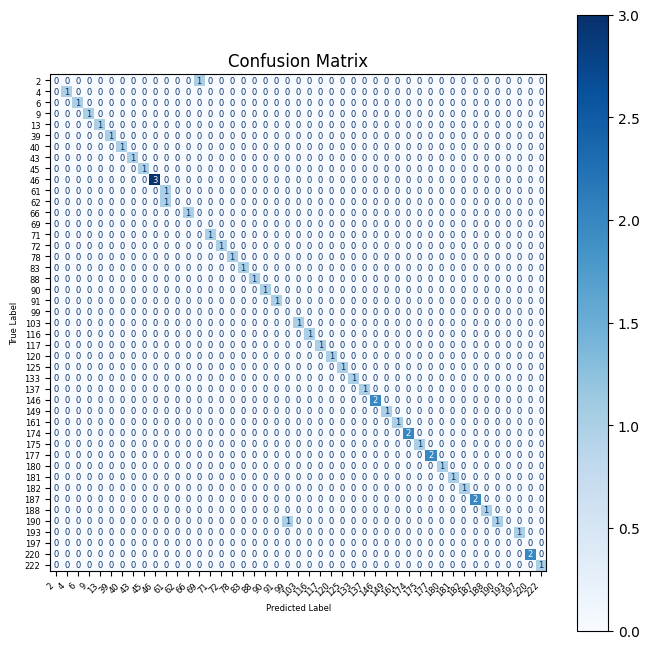

In [10]:
# Get predictions for the test set with confusion matrix report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt  # Explicitly import plt

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_masks = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask=attention_masks)
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix with unique labels present in the subset
unique_labels = sorted(list(set(all_labels[:50] + all_preds[:50])))
cm = confusion_matrix(all_labels[:50], all_preds[:50], labels=unique_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=unique_labels)

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, ax=ax)

plt.xticks(rotation=45, ha='right', fontsize=6)
plt.yticks(fontsize=6)
plt.xlabel("Predicted Label", fontsize=6)
plt.ylabel("True Label", fontsize=6)
plt.title("Confusion Matrix", fontsize=12)


for text in ax.texts:
    text.set_fontsize(6)

plt.show()

In [11]:
# Saving test evaluation results
evaluation_results = {
    "loss": f'{avg_loss * 100:.2f}%',
    "accuracy": f'{accuracy * 100:.2f}%',
    "precision": f'{precision * 100:.2f}%',
    "recall": f'{recall * 100:.2f}%',
    "f1": f'{f1 * 100:.2f}%'
}
with open(os.path.join(save_directory, 'test_evaluation_results.json'), 'w') as f:
    json.dump(evaluation_results, f)
print("Evaluation results saved to test_evaluation_results.json")

Evaluation results saved to test_evaluation_results.json


<font color="#006400"><h1>Part V - Implement Explainability/Transparency and Evaluate Model</h1></font>

In [12]:
# Model predictions with confidence
def predict_with_confidence(text, model, tokenizer, class_names):
    tokenized = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to(device)

    # Get model predictions
    with torch.no_grad():
        outputs = model(**tokenized)
        logits = outputs.logits

        # Validate class_names length
        if len(class_names) != logits.shape[1]:
            raise ValueError(
                f"Mismatch: class_names has {len(class_names)} entries but the model outputs {logits.shape[1]} classes."
            )

        probabilities = torch.softmax(logits, dim=1).cpu().numpy()[0]

    # Get the top prediction and its confidence
    predicted_index = probabilities.argmax()
    predicted_class = class_names[predicted_index]
    confidence = probabilities[predicted_index]

    # Generate a detailed explanation using highlight_tokens
    explanation = highlight_tokens(text, tokenized, model, tokenizer)

    return {
        "predicted_class": predicted_class,
        "confidence": confidence,
        "explanation": explanation
    }

def highlight_tokens(text, tokenized, model, tokenizer, ngram_size=2):
    try:
        if hasattr(model, 'bert') and hasattr(model.bert, 'encoder'):
            with torch.no_grad():
                outputs = model.bert(**tokenized, output_attentions=True)
                attentions = outputs.attentions
                last_layer_attention = attentions[-1].mean(dim=1)  # Average over heads
                token_importance = last_layer_attention[0].sum(dim=0).cpu().numpy()

            tokens = tokenizer.convert_ids_to_tokens(tokenized['input_ids'][0])
            punctuation = set([".", ",", "!", "?", ";", ":"])

            # Filter out special tokens, punctuation, and stopwords
            filtered_tokens = [
                (token, score)
                for token, score in zip(tokens, token_importance)
                if token not in ["[CLS]", "[SEP]", "[PAD]"] and
                   token.lower() not in stop_words and
                   token not in punctuation
            ]

            # --- Subword Merging ---
            merged_tokens = []
            current_word = ""
            current_score = 0  # Initialize current_score
            for token, score in filtered_tokens:
                if token.startswith("##"):
                    current_word += token[2:]
                    current_score += score
                else:
                    if current_word:
                        merged_tokens.append((current_word, current_score))
                    current_word = token
                    current_score = score
            if current_word:
                merged_tokens.append((current_word, current_score))  # Add last word
            # --- End of Subword Merging ---

            # Use merged_tokens for n-grams and further processing
            ngram_tokens = list(ngrams([token for token, _ in merged_tokens], ngram_size))
            ngram_scores = [
                (" ".join(ngram), sum(merged_tokens[i][1] for i in range(idx, idx + ngram_size)))
                for idx, ngram in enumerate(ngram_tokens)
            ]

            # Convert scores to percentages
            total_importance = sum(score for _, score in ngram_scores)
            ngram_scores = [(ngram, (score / total_importance) * 100) for ngram, score in ngram_scores]

            # Sort by importance and select the top tokens/phrases
            significant_ngrams = sorted(ngram_scores, key=lambda x: x[1], reverse=True)[:5]

            # Format the explanation
            explanation = "The most influential words/phrases for this prediction are:\n"
            for ngram, importance in significant_ngrams:
                explanation += f"  - {ngram}: {importance:.2f}%\n"

        else:
            explanation = "Attention scores unavailable for explanation."
    except Exception as e:
        explanation = f"Error generating explanation: {str(e)}"

    return explanation

# Example usage
class_names = [label for label, _ in sorted(label_mapping.items(), key=lambda x: x[1])]

# Input text
sample_text = "The patient reported feeling persistently sad."

result = predict_with_confidence(sample_text, model, tokenizer, class_names)

print(f"Predicted Class: {result['predicted_class']}")
print(f"Confidence: {result['confidence'] * 100:.0f}%")
print(f"Explanation: {result['explanation']}")


Predicted Class: prolonged grief disorder
Confidence: 72%
Explanation: The most influential words/phrases for this prediction are:
  - persistently sad: 27.89%
  - feeling persistently: 25.26%
  - reported feeling: 23.67%
  - patient reported: 23.18%



In [13]:
# Test model on sample patient symptoms input
sample_text = "I have been mildly interested in new activities. I have felt slightly down but not often. I have started more projects than usual but not excessively. I have not felt nervous or anxious. I have experienced some unexplained aches but not frequently. I have not had any thoughts of hurting myself. I have not heard voices or unusual sounds. I have experienced mild trouble with sleep quality. I have had no significant memory problems. I have not had obsessive thoughts. I have felt a bit detached from myself at times. I have consumed alcohol (4 drinks) and used substances occasionally without prescription."

result = predict_with_confidence(sample_text, model, tokenizer, class_names)

print(f"Predicted Class: {result['predicted_class']}")
print(f"Confidence: {result['confidence'] * 100:.0f}%")
print(f"Explanation: {result['explanation']}")

Predicted Class: generalized anxiety disorder
Confidence: 25%
Explanation: The most influential words/phrases for this prediction are:
  - unexplained aches: 5.16%
  - problemsbsessive thoughts: 4.27%
  - consumed alcohol: 4.14%
  - memory problemsbsessive: 4.11%
  - experienced unexplained: 4.07%



<font color="#006400"><h1>Part VI - Implement Feedback Mechanism</h1></font>

In [14]:
# Function to get clinician feedback
def get_clinician_feedback(predicted_class, confidence, explanation, actual_diagnosis=None):
    """
    Collects feedback from a clinician on the model's prediction.

    Args:
        predicted_class (str): Diagnosis predicted by the model.
        confidence (float): Confidence score for the prediction.
        explanation (str): Explanation for the model's prediction.
        actual_diagnosis (str, optional): The actual diagnosis from the clinician.

    Returns:
        dict: A dictionary containing the clinician's feedback.
    """
    print("\n--- Clinician Feedback Form ---")
    print(f"Predicted Diagnosis: {predicted_class} (Confidence: {confidence:.2f})")
    print("Explanation:")
    print(explanation)

    if actual_diagnosis:
        print(f"Actual Diagnosis: {actual_diagnosis}")

    agreement = input("Do you agree with the prediction? (yes/no): ").strip().lower()
    insights = input("Any additional insights or concerns? ").strip()

    return {
        "predicted_class": predicted_class,
        "confidence": confidence,
        "explanation": explanation,
        "actual_diagnosis": actual_diagnosis,
        "agreement": agreement,
        "insights": insights
    }


In [15]:
# Explain predictions and get clinician input
def explain_and_evaluate_for_clinicians(model, tokenizer, class_names, case_data):
    """
    Explains predictions, collects clinician feedback, and stores results.

    Args:
        model: The fine-tuned model.
        tokenizer: Tokenizer for the model.
        class_names (list): List of class names corresponding to model output classes.
        case_data (list): A list of dictionaries, each containing:
            'text': The patient's text description.
            'diagnosis' (optional): The actual diagnosis (ground truth, if available).

    Returns:
        list: A list of dictionaries containing clinician feedback for each case.
    """
    clinician_feedback = []

    for case in case_data:
        text = case['text']
        actual_diagnosis = case.get('diagnosis')  # Optional ground truth

        # Generate prediction and explanation
        result = predict_with_confidence(text, model, tokenizer, class_names)

        # Collect feedback from clinician
        feedback = get_clinician_feedback(
            predicted_class=result['predicted_class'],
            confidence=result['confidence'],
            explanation=result['explanation'],
            actual_diagnosis=actual_diagnosis
        )

        clinician_feedback.append(feedback)

    return clinician_feedback


In [16]:
# Example case data
case_data = [
    {"text": "The patient reported feeling persistently sad and anxious.", "diagnosis": "depressive disorders"},
    {"text": "The patient has been experiencing trouble sleeping and concentrating.", "diagnosis": "sleep-wake disorders"}
]

# Run the evaluation
feedback_results = explain_and_evaluate_for_clinicians(model, tokenizer, class_names, case_data)

# Print results
print("\n--- Collected Clinician Feedback ---")
for feedback in feedback_results:
    print(feedback)



--- Clinician Feedback Form ---
Predicted Diagnosis: other specified somatic symptom and related disorder (Confidence: 0.24)
Explanation:
The most influential words/phrases for this prediction are:
  - persistently sad: 21.62%
  - reported feeling: 20.61%
  - patient reported: 20.13%
  - feeling persistently: 19.96%
  - sad anxious: 17.67%

Actual Diagnosis: depressive disorders
Do you agree with the prediction? (yes/no): No
Any additional insights or concerns? less confidence

--- Clinician Feedback Form ---
Predicted Diagnosis: circadian rhythm sleep-wake disorders (Confidence: 0.70)
Explanation:
The most influential words/phrases for this prediction are:
  - trouble sleeping: 26.76%
  - sleeping concentrating: 26.05%
  - patient experiencing: 23.66%
  - experiencing trouble: 23.54%

Actual Diagnosis: sleep-wake disorders
Do you agree with the prediction? (yes/no): Yes
Any additional insights or concerns? no

--- Collected Clinician Feedback ---
{'predicted_class': 'other specified 